In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
import fiona
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
import json
import datetime
from IPython.display import Image

/Users/kivan/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Downloading your Google location history
If you've previously enabled Google location reporting on your smartphone, your GPS data will be periodically uploaded to Google's servers.1 The decisions of when and how to upload this data are entirely obfuscated to the end user, but as you'll see below, Android appears to upload a GPS location every 60 seconds, at least in my case. That's plenty of data to work with.

Google provides a service called Takeout that allows us to export any personal Google data. How kind! We'll use Takeout to download our raw location history as a one-time snapshot. Since Latitude was retired, no API exists to access location history in real-time.2 Here's what to do:

Go to https://www.google.com/settings/takeout. Uncheck all services except "Location History"
The data will be in a json format, which works great for us. Download it in your favorite compression type.
When Google has finished creating your archive, you'll get an email notification and a link to download.
Download and unzip the file, and you should be looking at a LocationHistory.json file.
Working with location data in Pandas
Pandas is an incredibly powerful tool that simplifies working with complex datatypes and performing statistical analysis in the style of R. Because of its flexible structure, I find myself spending a fraction of the time coding the same solution as compared to pure Python.3 Find a great primer on using Pandas here. We won't be going too in depth.

So, you've installed Pandas. Let's get started! We'll read in the LocationHistory.json file from Google Takeout and create a DataFrame.



In [2]:
with open('LocationHistory.json', 'r') as fh:
    raw = json.loads(fh.read())

ld = pd.DataFrame(raw['locations'])
del raw #free up some memory
# convert to typical units
ld['latitudeE7'] = ld['latitudeE7']/float(1e7) 
ld['longitudeE7'] = ld['longitudeE7']/float(1e7)
ld['timestampMs'] = ld['timestampMs'].map(lambda x: float(x)/1000) #to seconds
ld['datetime'] = ld.timestampMs.map(datetime.datetime.fromtimestamp)
# Rename fields based on the conversions we just did
ld.rename(columns={'latitudeE7':'latitude', 'longitudeE7':'longitude', 'timestampMs':'timestamp'}, inplace=True)
ld = ld[ld.accuracy < 1000] #Ignore locations with accuracy estimates over 1000m
ld.reset_index(drop=True, inplace=True)

Now you've got a Pandas DataFrame called ld containing all your location history and related info. 
We've got latitude, longitude, and a timestamp (obviously), but also accuracy, activitys [sic], altitude, heading. 
Google is clearly trying to do some complex backend analysis of your location history to infer what you're up to and where you're going (and you'll see some of these fields in use if you use Google Now on your smartphone). But all we'll need is latitude, longitude, and time.



# Working with Shapefiles in Python

The more I learn about mapping, the more I realize how complex it is. But to do what we want to do with our location history, we're going to have to become experts in mapping in a couple hours. We don't have time to learn proprietary GIS software or write our own methods to analyze map data. But Python being Python, we've already got packages to knock this stuff out.

Shapefile is a widely-used data format for describing points, lines, and polygons. To work with shapefiles, Python gives us Shapely.4 Shapely rocks. To briefly read/write shapefiles, we'll use Fiona.

To learn Shapely and write this blog post, I leaned heavily on an article from sensitivecities.com. Please, go pester that guy to write more stuff. Tom MacWright also wrote a great overview of the tools we'll be using.

First up, you'll need to download shapefile data for the part of the world you're interested in plotting. I wanted to focus on my current home of Seattle, which like many cities provides city shapefile map data for free. It's even broken into city neighborhoods! The US Census Bureau provides a ton of national shapefiles here. Your city likely provides this kind of data too.

Next, we'll need to import the Shapefile data we downloaded, which is easy as pie.

In [3]:
shapefilename = 'data/Neighborhoods/WGS84/Neighborhoods'
shp = fiona.open(shapefilename+'.shp')
coords = shp.bounds
shp.close()

w, h = coords[2] - coords[0], coords[3] - coords[1]
extra = 0.01

Now we'll leverage Basemap to go about actually plotting our shapefiles.



In [4]:
m = Basemap(
    projection='tmerc', ellps='WGS84',
    lon_0=np.mean([coords[0], coords[2]]),
    lat_0=np.mean([coords[1], coords[3]]),
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - (extra * h), 
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + (extra * h),
    resolution='i',  suppress_ticks=True)

_out = m.readshapefile(shapefilename, name='seattle', drawbounds=False, color='none', zorder=2)

# Step 1: Prep data and pare down locations
The first step is to pare down your location history to only contain points within the map's borders.


In [5]:
# set up a map dataframe
df_map = pd.DataFrame({
    'poly': [Polygon(hood_points) for hood_points in m.seattle],
    'name': [hood['S_HOOD'] for hood in m.seattle_info]
})
# Convert our latitude and longitude into Basemap cartesian map coordinates
mapped_points = [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(ld['longitude'], 
            ld['latitude'])]
all_points = MultiPoint(mapped_points)
# Use prep to optimize polygons for faster computation
hood_polygons = prep(MultiPolygon(list(df_map['poly'].values)))
# Filter out the points that do not fall within the map we're making
city_points = filter(hood_polygons.contains, all_points)


Now, city_points contains a list of all points that fall within the map and hood_polygons is a collection of polygons representing, in my case, each neighborhood in Seattle.

# Step 2: Compute your measurement metric
The raw data for my choropleth should be "number of points in each neighborhood." With Pandas, again, it's easy. (Warning - depending on the size of the city_points array, this could take a few minutes.)

In [6]:
def num_of_contained_points(apolygon, city_points):
    return int(len(filter(prep(apolygon).contains, city_points)))

In [7]:
df_map['hood_count'] = df_map['poly'].apply(num_of_contained_points, args=(city_points,))
df_map['hood_hours'] = df_map.hood_count/60.0


So now, df_map.hood_count contains a count of the number of gps points located within each neighborhood. But what do those counts really mean? It's not very meaningful knowing that I spent 2,500 "datapoints" in Capitol Hill, except to compare against other neighborhoods. And we could do that. Or we could convert hood_count into time...

Turns out, that's really easy, for one simple reason. From investigating my location history, it seems that unless my phone is off or without reception, Android reports my location exactly every 60 seconds. Not usually 60 seconds, not sometimes 74 seconds, 60 seconds. It's been true on Android 4.2-4.4, and using a Samsung S3 and my current Nexus 5. Hopefully that means it holds true for you, too.6 So if we make the assumption that I keep my phone on 24/7 (true) and I have city-wide cellular reception (also true), then all we need to do is hood_count/60.0, as shown above, and now we're talking in hours instead of datapoints7.

# Step 3: Plot the choropleth
We've got our location data. We've got our shapefiles in order. All that's left - plot! Note that I've removed location data near my work and home, partly so they don't skew the colormap, and partly to anonymize my data just an eensy bit.

This plotting code for the choropleth gets a bit wordy for a blog format, so check the code as a Gist at the below link.




In [8]:
#%run choropleth.py

In [9]:
# Check out the full post at http://beneathdata.com/how-to/visualizing-my-location-history/
# to utilize the code below

# We'll only use a handful of distinct colors for our choropleth. So pick where
# you want your cutoffs to occur. Leave zero and ~infinity alone.
breaks = [0.] + [4., 24., 64., 135.] + [1e20]
def self_categorize(entry, breaks):
    for i in range(len(breaks)-1):
        if entry > breaks[i] and entry <= breaks[i+1]:
            return i
    return -1
df_map['jenks_bins'] = df_map.hood_hours.apply(self_categorize, args=(breaks,))

labels = ['Never been\nhere']+["> %d hours"%(perc) for perc in breaks[:-1]]

# Or, you could always use Natural_Breaks to calculate your breaks for you:
from pysal.esda.mapclassify import Natural_Breaks
breaks = Natural_Breaks(df_map[df_map['hood_hours'] > 0].hood_hours, initial=300, k=3)
df_map['jenks_bins'] = -1 #default value if no data exists for this bin
df_map['jenks_bins'][df_map.hood_count > 0] = breaks.yb
# 
jenks_labels = ['Never been here', "> 0 hours"]+["> %d hours"%(perc) for perc in breaks.bins[:-1]]

def custom_colorbar(cmap, ncolors, labels, **kwargs):    
    """Create a custom, discretized colorbar with correctly formatted/aligned labels.
    
    cmap: the matplotlib colormap object you plan on using for your graph
    ncolors: (int) the number of discrete colors available
    labels: the list of labels for the colorbar. Should be the same length as ncolors.
    """
    from matplotlib.colors import BoundaryNorm
    from matplotlib.cm import ScalarMappable
        
    norm = BoundaryNorm(range(0, ncolors), cmap.N)
    mappable = ScalarMappable(cmap=cmap, norm=norm)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors+1)+0.5)
    colorbar.set_ticklabels(range(0, ncolors))
    colorbar.set_ticklabels(labels)
    return colorbar

figwidth = 14
fig = plt.figure(figsize=(figwidth, figwidth*h/w))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

cmap = plt.get_cmap('Blues')
# draw neighborhoods with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#111111', lw=.8, alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)
# apply our custom color values onto the patch collection
cmap_list = [cmap(val) for val in (df_map.jenks_bins.values - df_map.jenks_bins.values.min())/(
                  df_map.jenks_bins.values.max()-float(df_map.jenks_bins.values.min()))]
pc.set_facecolor(cmap_list)
ax.add_collection(pc)

#Draw a map scale
m.drawmapscale(coords[0] + 0.08, coords[1] + -0.01,
    coords[0], coords[1], 10.,
    fontsize=16, barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555', fontcolor='#555555',
    zorder=5, ax=ax,)

# ncolors+1 because we're using a "zero-th" color
cbar = custom_colorbar(cmap, ncolors=len(jenks_labels)+1, labels=jenks_labels, shrink=0.5)
cbar.ax.tick_params(labelsize=16)

fig.suptitle("Time Spent in Seattle Neighborhoods", fontdict={'size':24, 'fontweight':'bold'}, y=0.92)
ax.set_title("Using location data collected from my Android phone via Google Takeout", fontsize=14, y=0.98)
ax.text(1.35, 0.04, "Collected from 2012-2014 on Android 4.2-4.4\nGeographic data provided by data.seattle.gov", 
    ha='right', color='#555555', style='italic', transform=ax.transAxes)
ax.text(1.35, 0.01, "kivanpolimis.com", color='#555555', fontsize=16, ha='right', transform=ax.transAxes)

plt.savefig('chloropleth.png', dpi=100, frameon=False, bbox_inches='tight', pad_inches=0.5, facecolor='#F2F2F2')

/Users/kivan/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


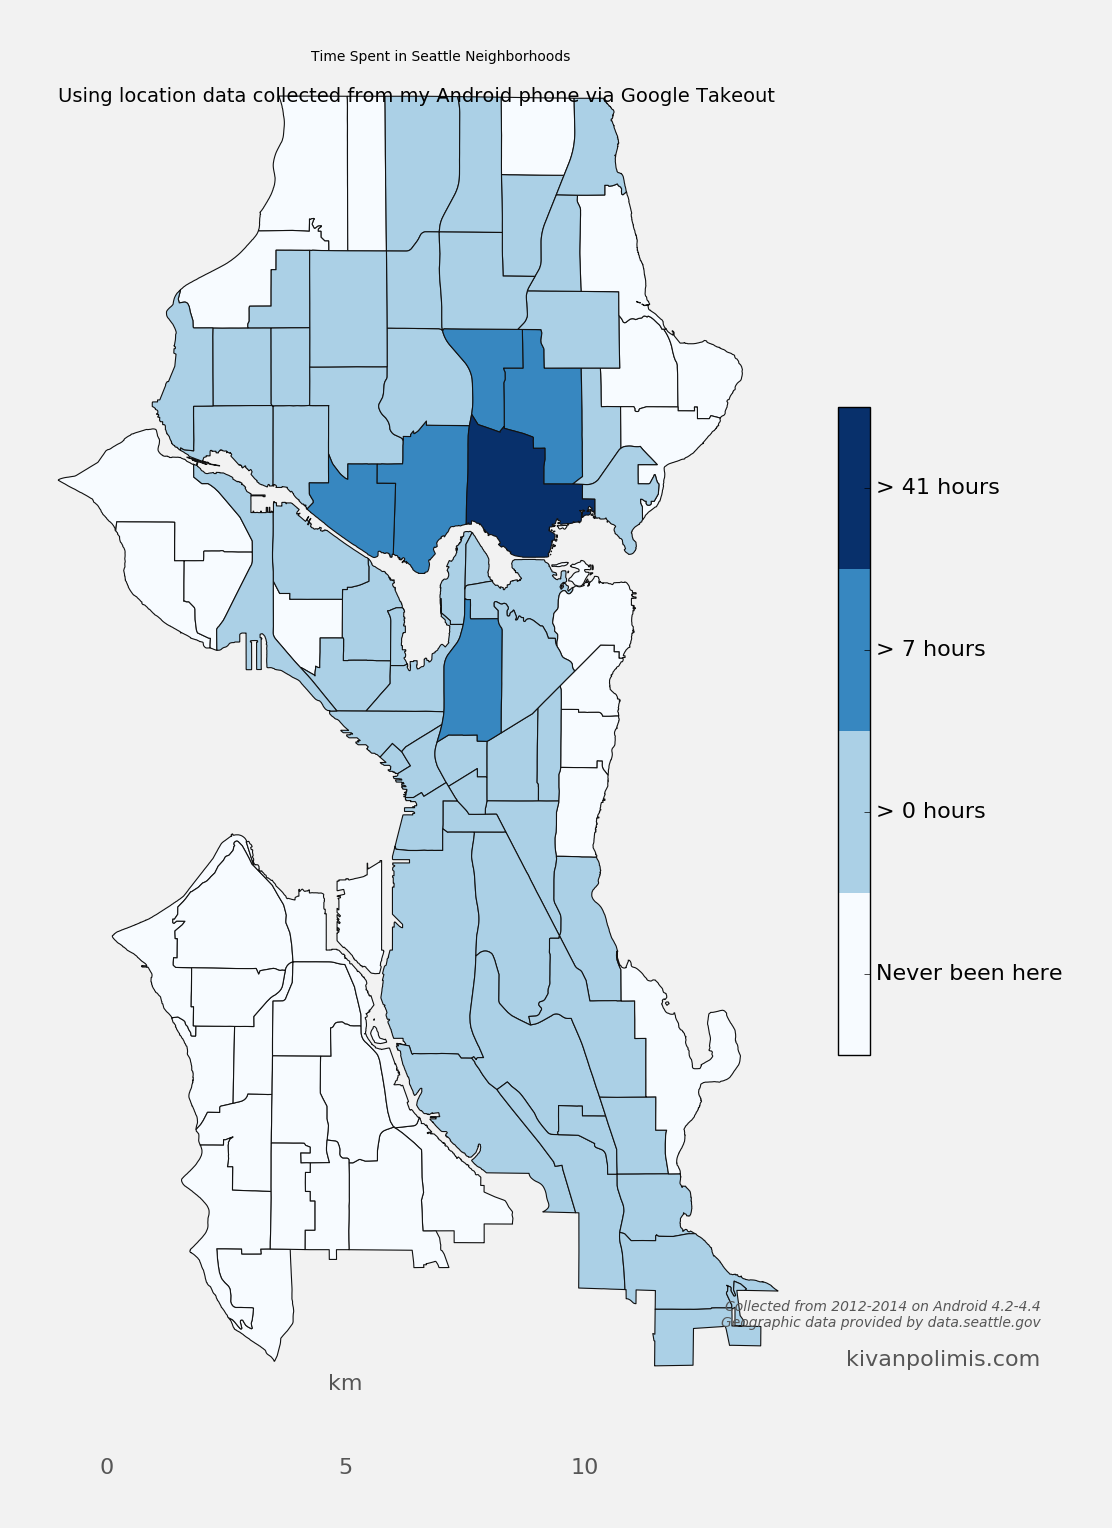

In [10]:
Image("chloropleth.png")

# Hexbin Map
We can also take a different approach to choropleths, and instead of using each neighborhood polygon as a bin, let Basemap generate uniform hexagonal bins for us! It's a great way to visualize point density, as all our bins will be of equal size. Best of all, it requires essentially no extra work as we've already defined our neighborhood Patches and paired down our location data. See the code below in the Gist.

In [11]:
#%run hexbin.py

In [12]:
"""PLOT A HEXBIN MAP OF LOCATION
"""
figwidth = 14
fig = plt.figure(figsize=(figwidth, figwidth*h/w))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# draw neighborhood patches from polygons
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, fc='#555555', ec='#555555', lw=1, alpha=1, zorder=0))
# plot neighborhoods by adding the PatchCollection to the axes instance
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

# the mincnt argument only shows cells with a value >= 1
# The number of hexbins you want in the x-direction
numhexbins = 50
hx = m.hexbin(
    np.array([geom.x for geom in city_points]),
    np.array([geom.y for geom in city_points]),
    gridsize=(numhexbins, int(numhexbins*h/w)), #critical to get regular hexagon, must stretch to map dimensions
    bins='log', mincnt=1, edgecolor='none', alpha=1.,
    cmap=plt.get_cmap('Blues'))

# Draw the patches again, but this time just their borders (to achieve borders over the hexbins)
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, fc='none', ec='#FFFF99', lw=1, alpha=1, zorder=1))
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))

# Draw a map scale
m.drawmapscale(coords[0] + 0.05, coords[1] - 0.01,
    coords[0], coords[1], 4.,
    units='mi', barstyle='fancy', labelstyle='simple',
    fillcolor1='w', fillcolor2='#555555', fontcolor='#555555',
    zorder=5)

fig.suptitle("My location density in Seattle", fontdict={'size':24, 'fontweight':'bold'}, y=0.92)
ax.set_title("Using location data collected from my Android phone via Google Takeout", fontsize=14, y=0.98)
ax.text(1.0, 0.03, "Collected from 2012-2014 on Android 4.2-4.4\nGeographic data provided by data.seattle.gov", 
        ha='right', color='#555555', style='italic', transform=ax.transAxes)
ax.text(1.0, 0.01, "kivanpolimis.com", color='#555555', fontsize=16, ha='right', transform=ax.transAxes)
plt.savefig('hexbin.png', dpi=100, frameon=False, bbox_inches='tight', pad_inches=0.5, facecolor='#DEDEDE')

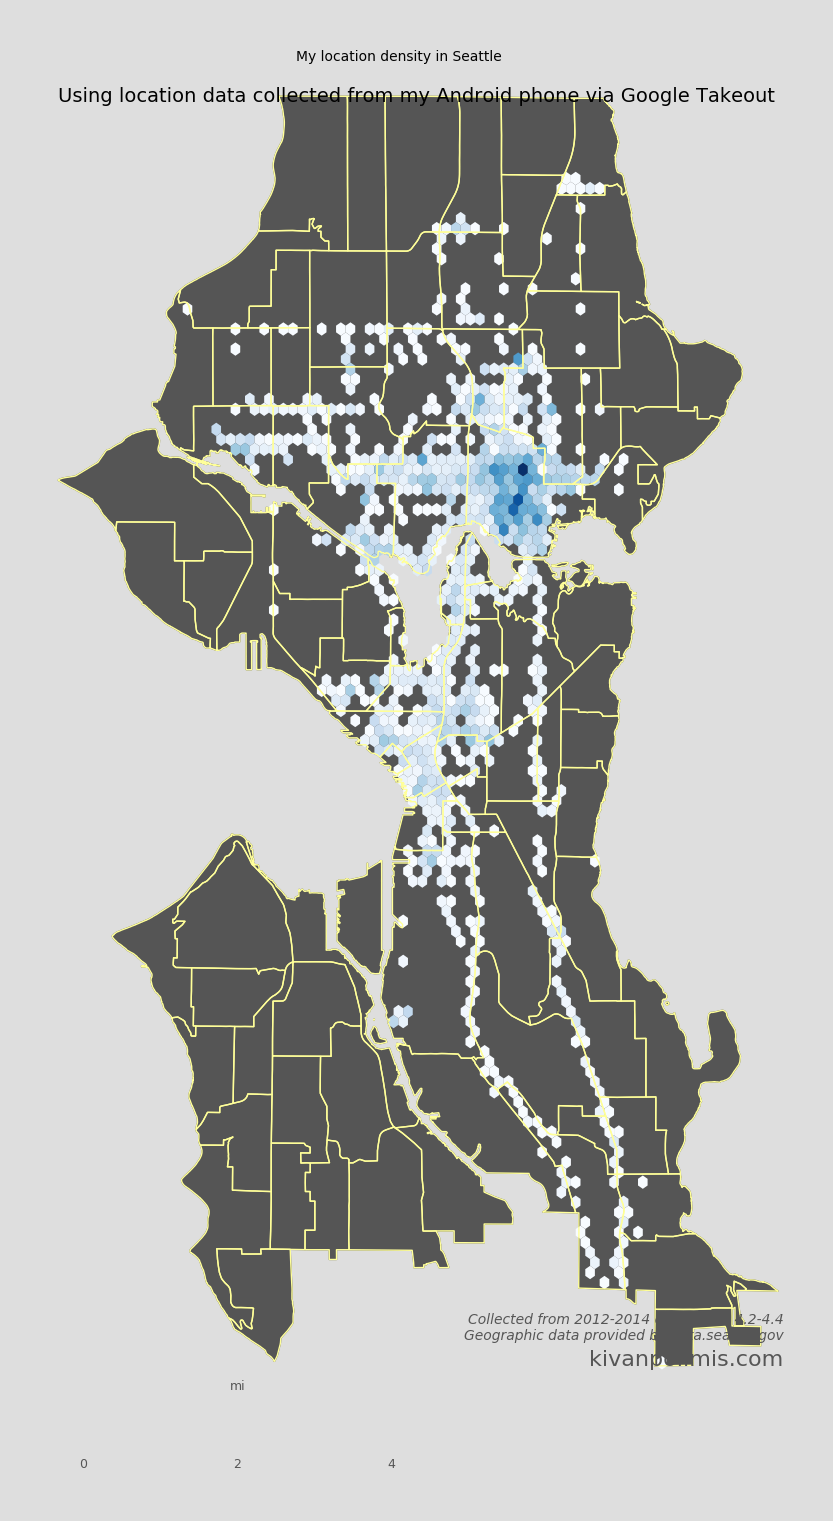

In [13]:
Image("hexbin.png")

Some super interesting patterns pop out immediately. I pretty much just hang out in North Seattle and Downtown. You can quickly spot my time on the Burke-Gilman trail on the east side, and you can also spot some of my favorite hangouts. Some of my friends may even see their houses on here (remember I've removed location data from near my work and home).

Of course, I don't always have my phone with me, and I notice some glaring vacancies on the map where I know I've been like Discovery Park, Madison, West Seattle, Seward Park, etc. But all in all, pretty awesome graph.

